In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('SpotifyFeatures.csv') 






### Limpieza Dataset Spotify

In [2]:
# Cargar el dataset
df = pd.read_csv("SpotifyFeatures.csv")

# 1. Valores faltantes
print("Valores faltantes por:")
print(df.isnull().sum())
df.fillna(df.mean(numeric_only=True), inplace=True)

# 2. Identificar outliers
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR)))
print("Número de outliers:")
print(outliers.sum())

# 3. Estandarizar formatos
df['track_id'] = df['track_id'].astype(str)  # ID como texto
df['duration_ms'] = df['duration_ms'].astype(int)  # Asegurar duración como entero
df['time_signature'] = df['time_signature'].str.replace('/4', '').astype(int)  # Compases 

# 4. Identificar y eliminar duplicados
print(f"Número de filas duplicadas: {df.duplicated().sum()}")
df = df.drop_duplicates()

Valores faltantes por:
genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64
Número de outliers:
popularity             38
acousticness            0
danceability            0
duration_ms         14651
energy                  0
instrumentalness    51545
liveness            21241
loudness            14171
speechiness         32979
tempo                 168
valence                 0
dtype: int64
Número de filas duplicadas: 0


### RFM

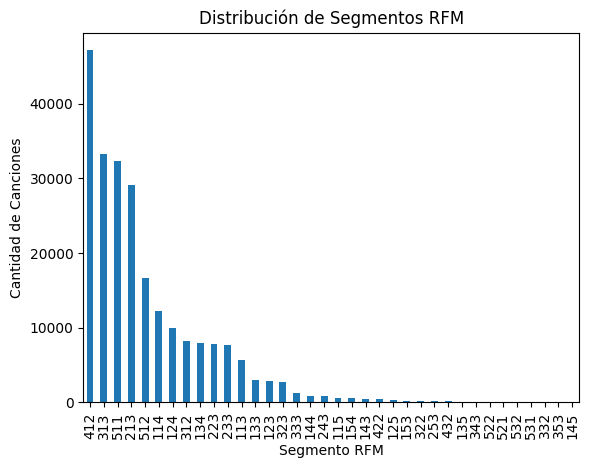

In [12]:
# 1. RFM - Calcular métricas
# R: Última vez escuchada, F: Frecuencia de aparición, M: Popularidad
df['recency'] = df['popularity'].rank(ascending=False)  # ranking para 'recency'
df['frequency'] = df.groupby('track_id')['track_id'].transform('count')  # Frecuencia de cada canción
df['monetary'] = df['popularity']  # popularidad como valor monetario

# 2. Asignar Scores (1-5)
df['R_score'] = pd.cut(df['recency'], bins=5, labels=[1, 2, 3, 4, 5])
df['F_score'] = pd.cut(df['frequency'], bins=5, labels=[1, 2, 3, 4, 5])
df['M_score'] = pd.cut(df['monetary'], bins=5, labels=[1, 2, 3, 4, 5])

# 3. Crear Segmentos
df['RFM_Segment'] = df['R_score'].astype(str) + df['F_score'].astype(str) + df['M_score'].astype(str)

# 4. Visualización
import matplotlib.pyplot as plt
df['RFM_Segment'].value_counts().plot(kind='bar')
plt.title("Distribución de Segmentos RFM")
plt.xlabel("Segmento RFM")
plt.ylabel("Cantidad de Canciones")
plt.show()



### Segmentación

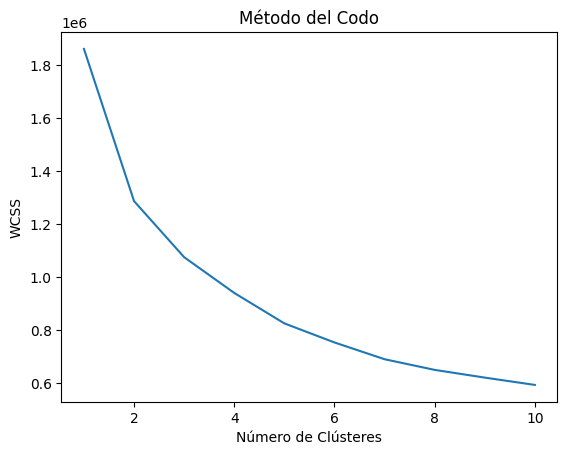

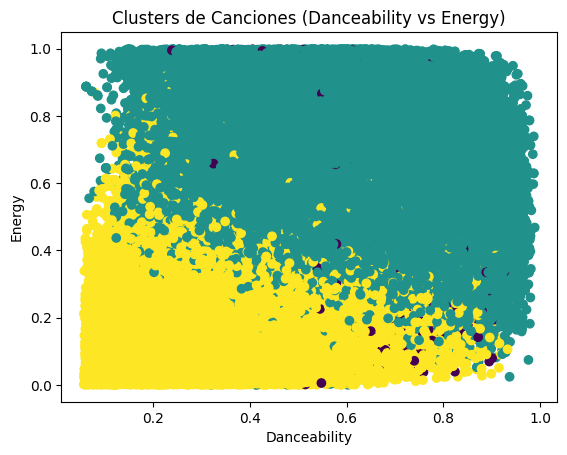

In [13]:
# 1. Preparación
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']
df_features = df[features]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

# 2. Clustering - Método del codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# método del codo
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('WCSS')
plt.show()

# 3. K-means
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualización
plt.scatter(df['danceability'], df['energy'], c=df['Cluster'], cmap='viridis')
plt.title("Clusters de Canciones (Danceability vs Energy)")
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.show()


### CLV

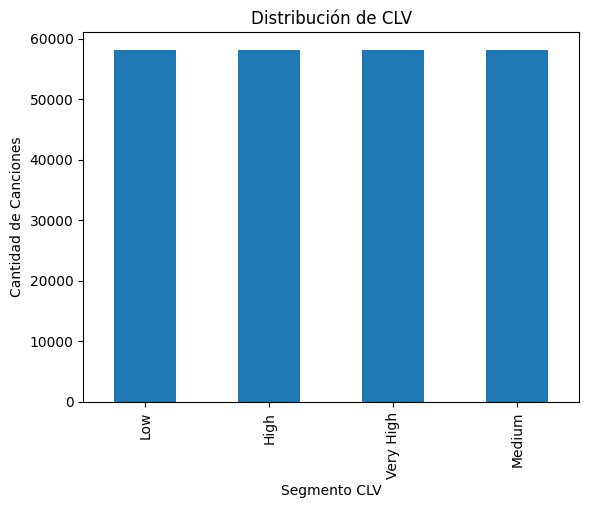

In [14]:
# 1. Métricas base (Valor promedio, Frecuencia, Tiempo de vida)
df['avg_value'] = df['popularity'].mean()  # Valor promedio de las canciones
df['frequency'] = df.groupby('track_id')['track_id'].transform('count')  # Frecuencia
df['lifetime'] = df['duration_ms'] / 1000 / 60  # Tiempo de vida en minutos

# 2. Cálculo CLV (Valor Promedio * Frecuencia * Tiempo de vida)
df['CLV'] = df['avg_value'] * df['frequency'] * df['lifetime']

# 3. Segmentación
df['CLV_segment'] = pd.qcut(df['CLV'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# 4. Visualización
df['CLV_segment'].value_counts().plot(kind='bar')
plt.title("Distribución de CLV")
plt.xlabel("Segmento CLV")
plt.ylabel("Cantidad de Canciones")
plt.show()